In [1]:
import torch

In [2]:
import numpy as np
import matplotlib as plt

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /var/tmp/pip-req-build-q96_qlg7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /var/tmp/pip-req-build-q96_qlg7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q roboflow supervision

In [33]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

In [36]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth'

In [4]:
from segment_anything import sam_model_registry

In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_l"
CHECKPOINT_PATH = "./sam_vit_l_0b3195.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## Automated Mask Generation with SAM

In [6]:
torch.cuda.empty_cache()

In [6]:
# Unzip images zip

import zipfile

zip_file = "images.zip"  # Replace 'your_zip_file.zip' with the name of your zip file

# Specify the directory where you want to extract the contents of the zip file
extract_dir = "images"  # Replace 'destination_directory' with your desired destination directory

# Open the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

In [18]:
import os
import cv2
from segment_anything import SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import numpy as np

# Initialize the mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Specify the folder containing the images
folder_path = "./images"

# Create a folder to save modified images if it doesn't exist
output_folder = "./segmented_images"
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
        # Read the image
        image_name = os.path.splitext(filename)[0]
        if os.path.exists(os.path.join("segmented_images", image_name)):
            print(f"Skipping segmentation for {image_name}, already segmented.")
            continue
        else:
            print(f"Starting segmentation for {image_name}.")
        
        image_path = os.path.join(folder_path, filename)
        image_bgr = cv2.imread(image_path)
        
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Generate segmentation mask for the image
        predictor = mask_generator.generate(image_rgb)
        
        # Calculate area for each mask and store in a list of tuples (index, area)
        mask_areas = [(i, np.sum(mask['segmentation'])) for i, mask in enumerate(predictor)]
        
        # Sort masks based on area in descending order
        sorted_masks = sorted(mask_areas, key=lambda x: x[1], reverse=True)
        
        # Create a subfolder for each image to save modified images
        image_output_folder = os.path.join(output_folder, filename.split('.')[0])
        os.makedirs(image_output_folder, exist_ok=True)
        
        # Counter to keep track of the number of masks processed
        mask_count = 0
        
        # Iterate over sorted masks
        for mask_index, area in sorted_masks:
            # Retrieve segmentation mask
            segmentation_mask = predictor[mask_index]['segmentation']
            
            # Make a copy of the original image
            modified_image = np.copy(image_rgb)
            
            # Remove background by turning it to white
            modified_image[segmentation_mask == False] = [255, 255, 255]
            
            # Save the modified image
            output_path = os.path.join(image_output_folder, f"{mask_index}.png")
            cv2.imwrite(output_path, cv2.cvtColor(modified_image, cv2.COLOR_RGB2BGR))
            
            # Increment the mask count
            mask_count += 1
            
            # Check if 20 masks have been processed, if so, break out of the loop
            if mask_count == 20:
                break

Skipping segmentation for 3147, already segmented.
Skipping segmentation for 2936, already segmented.
Skipping segmentation for 2972, already segmented.
Skipping segmentation for 4922, already segmented.
Skipping segmentation for 7063, already segmented.
Skipping segmentation for 23, already segmented.
Skipping segmentation for 11074, already segmented.
Skipping segmentation for 5112, already segmented.
Skipping segmentation for 7458, already segmented.
Skipping segmentation for 2865, already segmented.
Skipping segmentation for 7099, already segmented.
Skipping segmentation for 7081, already segmented.
Skipping segmentation for 11397, already segmented.
Skipping segmentation for 828, already segmented.
Skipping segmentation for 12806, already segmented.
Skipping segmentation for 11350, already segmented.
Skipping segmentation for 5105, already segmented.
Skipping segmentation for 4983, already segmented.
Skipping segmentation for 13146, already segmented.
Skipping segmentation for 154

In [ ]:
!find /path/to/your/directory -type d -mindepth 1 | wc -l

In [9]:
# Inference on a single image

In [8]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [9]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [10]:
print(os.environ.get("PYTORCH_CUDA_ALLOC_CONF"))

expandable_segments:True


In [14]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread("./images/4061.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [15]:
predictor = mask_generator.generate(image_rgb)

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.08 GiB. GPU 0 has a total capacity of 14.58 GiB of which 5.01 GiB is free. Including non-PyTorch memory, this process has 9.57 GiB memory in use. Of the allocated memory 9.14 GiB is allocated by PyTorch, and 304.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
len(predictor)

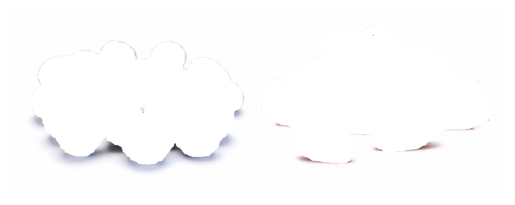

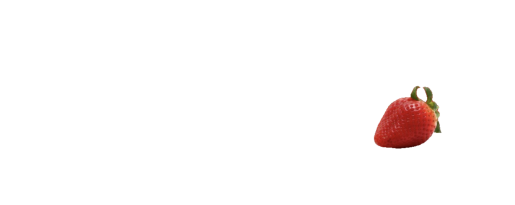

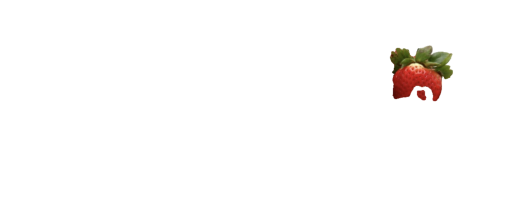

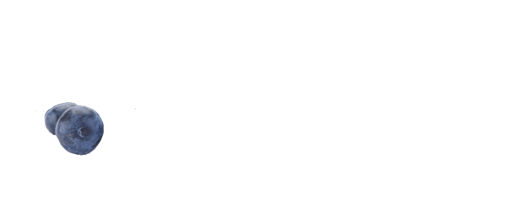

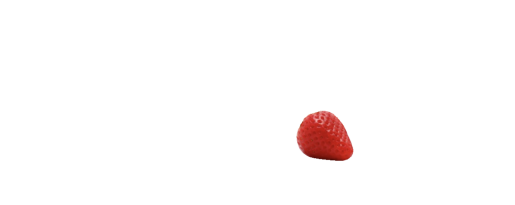

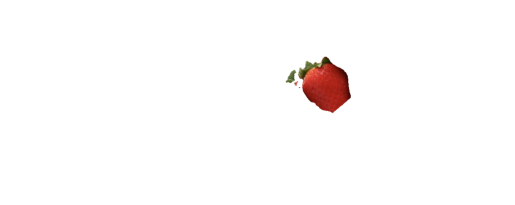

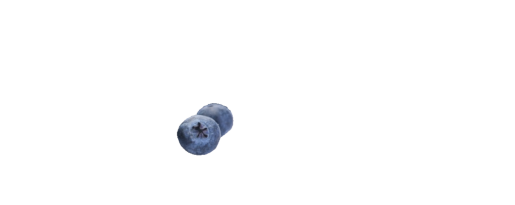

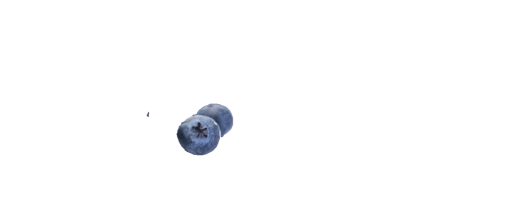

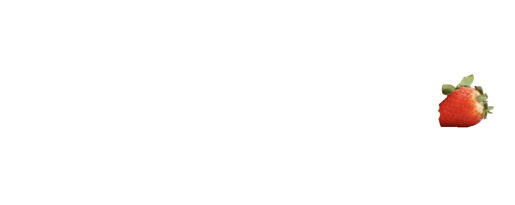

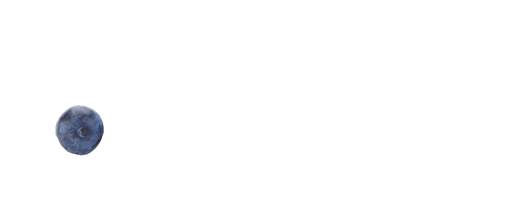

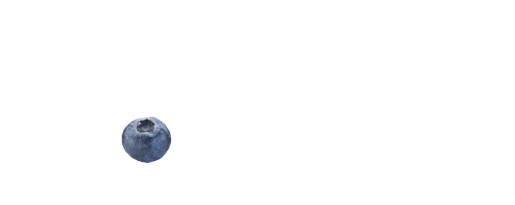

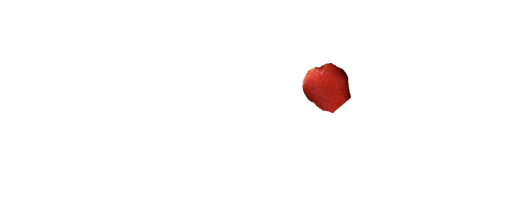

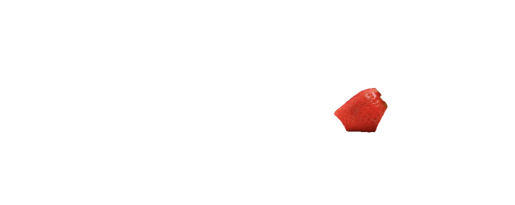

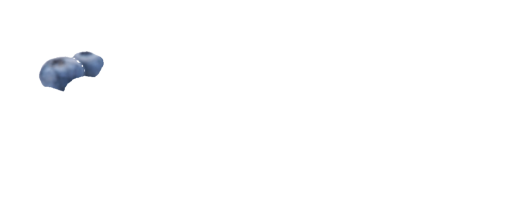

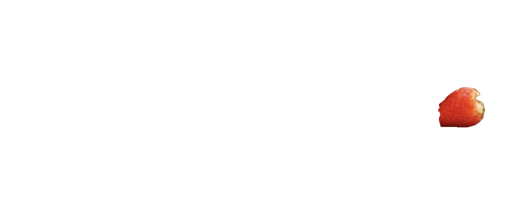

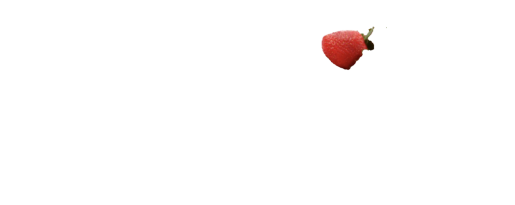

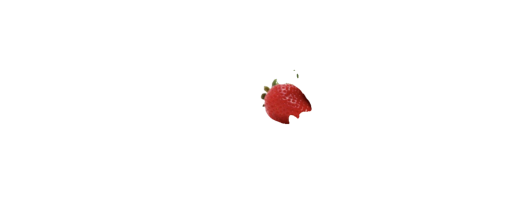

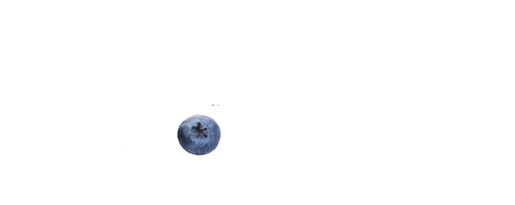

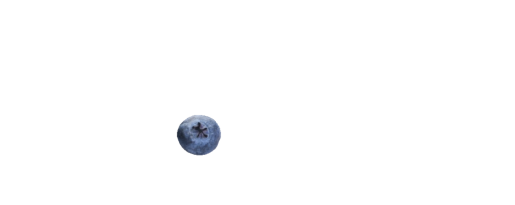

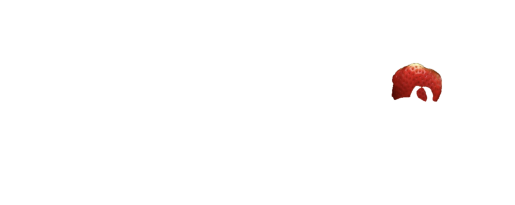

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate area for each mask and store in a list of tuples (index, area)
mask_areas = [(i, np.sum(mask['segmentation'])) for i, mask in enumerate(predictor)]

# Sort masks based on area in descending order
sorted_masks = sorted(mask_areas, key=lambda x: x[1], reverse=True)

# Counter to keep track of the number of masks processed
mask_count = 0

# Iterate over sorted masks
for mask_index, area in sorted_masks:
    # Retrieve segmentation mask
    segmentation_mask = predictor[mask_index]['segmentation']
    
    # Make a copy of the original image
    modified_image = np.copy(image_rgb)
    
    # Remove background by turning it to white
    modified_image[segmentation_mask == False] = [255, 255, 255]
    
    # Display the modified image
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
    #SAVE IMAGE
    #plt.savefig(f"modified_image_{mask_index}.png", bbox_inches='tight', pad_inches=0)
    
    # Increment the mask count
    mask_count += 1
    
    # Check if 10 masks have been processed, if so, break out of the loop
    if mask_count == 20:
        break

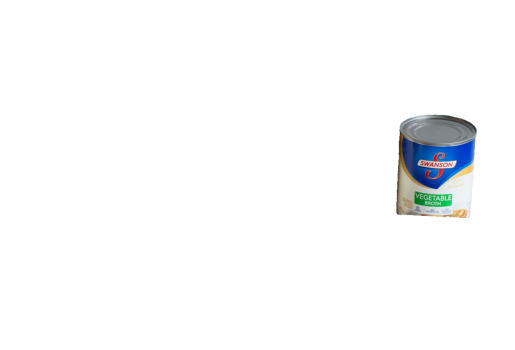

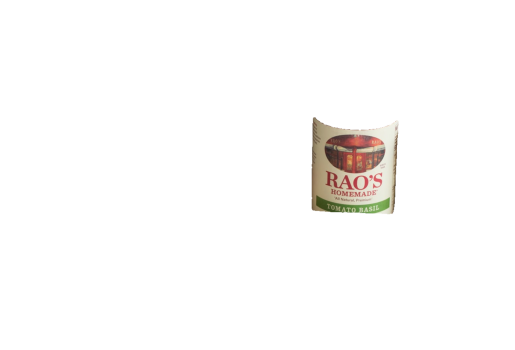

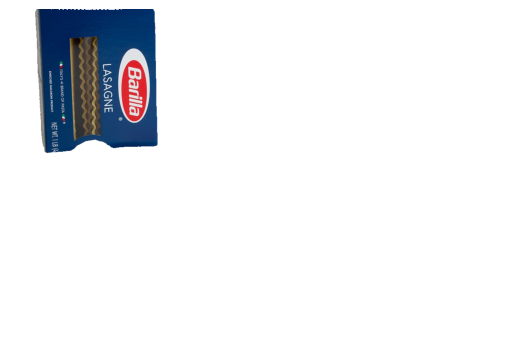

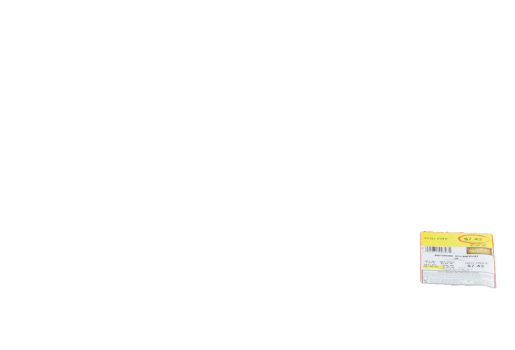

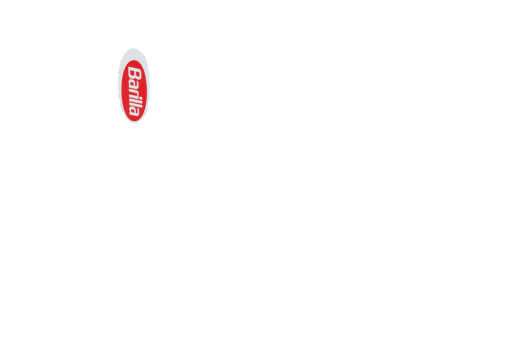

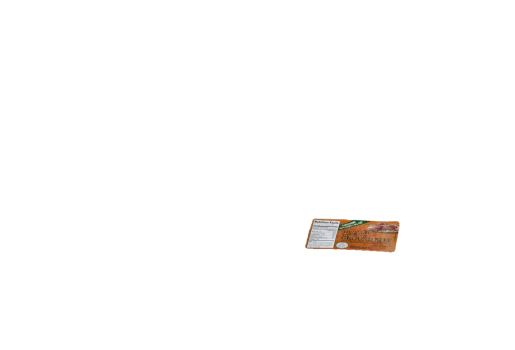

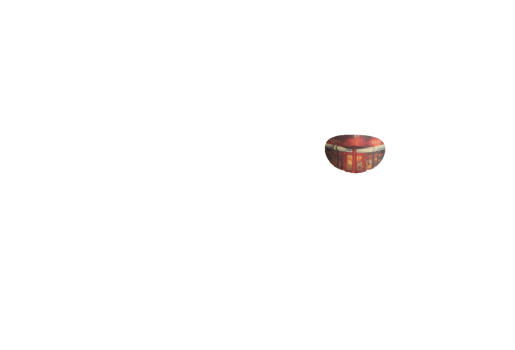

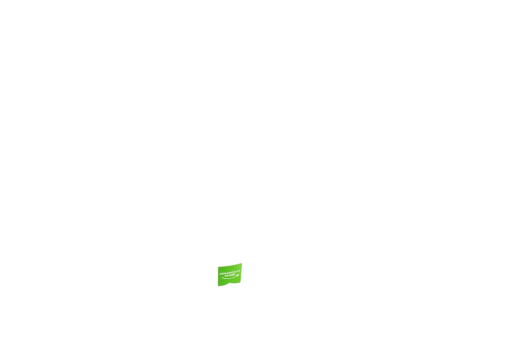

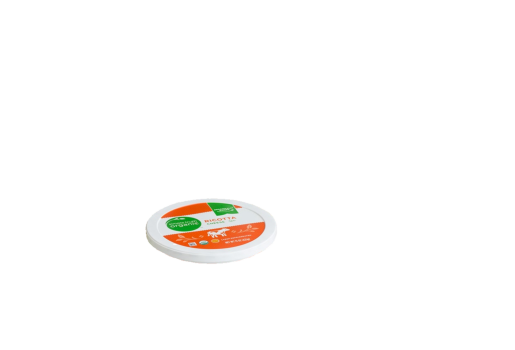

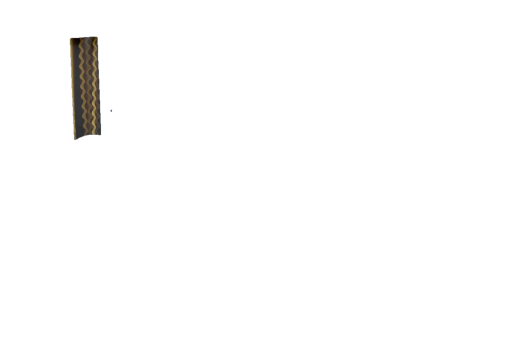

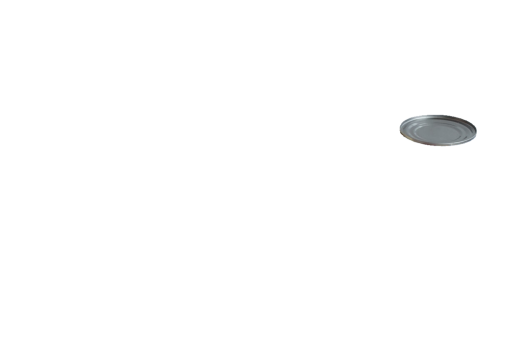

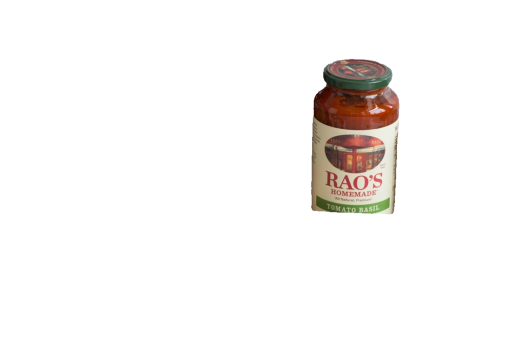

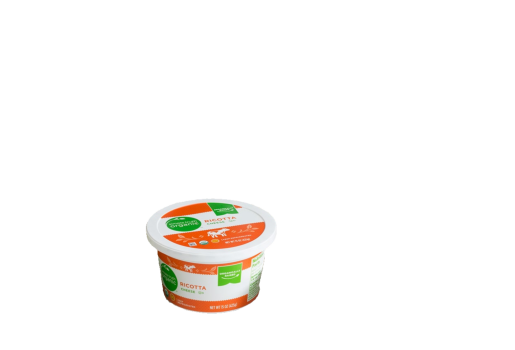

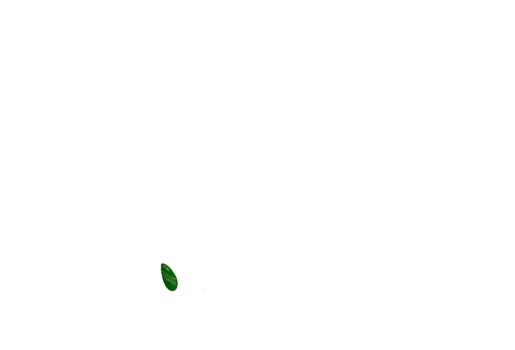

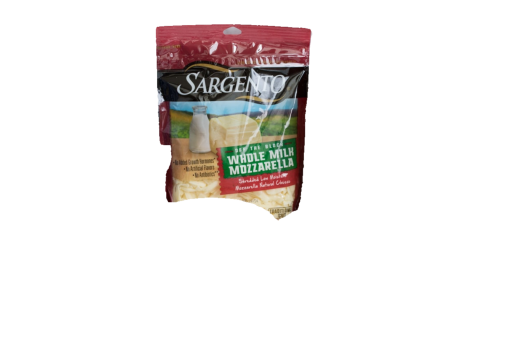

In [77]:
"""import matplotlib.pyplot as plt
import numpy as np

# Counter to keep track of the number of masks processed
mask_count = 0

# Iterate over each mask in predictor
for mask in predictor:
    segmentation_mask = mask['segmentation']
    
    # Make a copy of the original image
    modified_image = np.copy(image_rgb)
    
    # Remove background by turning it to white
    modified_image[segmentation_mask == False] = [255, 255, 255]

    # Display the modified image
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
    #SAVE IMAGE
    #plt.savefig(f"modified_image_{mask_index}.png", bbox_inches='tight', pad_inches=0)
    
    # Increment the mask count
    mask_count += 1
    
    # Check if 10 masks have been processed, if so, break out of the loop
    if mask_count == 15:
        break
"""

In [34]:
"""
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Counter to keep track of the number of masks processed
mask_count = 0

# Iterate over each mask in predictor
for mask in predictor:
    # Check if 10 masks have been processed, if so, break out of the loop
    if mask_count == 10:
        break
    
    segmentation_mask = mask['segmentation']
    
    # Resize mask to match image size
    resized_mask = resize(segmentation_mask, image_rgb.shape[:2], anti_aliasing=True)
    
    # Make a copy of the original image
    modified_image = np.copy(image_rgb)
    
    # Remove background by turning it to white
    modified_image[resized_mask == False] = [255, 255, 255]
    
    # Display the modified image
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
    # Increment the mask count
    mask_count += 1
"""

ValueError: anti_aliasing must be False for boolean images